In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [11]:
df = pd.read_csv("../data/spotify_millsongdata.csv")


In [12]:
df.head()


,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [13]:
df.shape


(57650, 4)

In [14]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [15]:

# content based recommendes system
df.isnull().sum()


artist    0
song      0
link      0
text      0
dtype: int64

In [16]:

# top artist and songs
top_artists = df['artist'].value_counts().head(10)
print("\nTop 10 Artists:")
print(top_artists)



Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [17]:

df = df.sample(10000)


In [18]:


df = df.drop('link', axis=1).reset_index(drop=True)


In [19]:

# Word cloud for sing lyrics
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400,background_color='white').generate(all_lyrics)



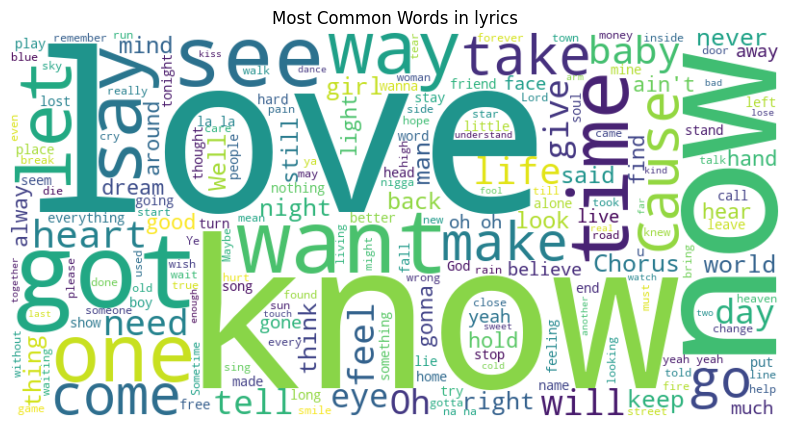

In [20]:

# word cloud to visualize the most common words in lyrics
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in lyrics")
plt.show()


In [21]:

# data preprocessing
df.shape


(10000, 3)

In [22]:
df.head(5)


,artist,song,text
0,Kid Rock,Say Goodbye,[Verse 1] \r\nWe haven't really talked about ...
1,Joni Mitchell,Cold Blue Steel And Sweet Fire,Cold blue steel out of money \r\nOne eye for ...
2,Unwritten Law,"Actress, Model...",Dear Mom \r\nI'm dating an actress \r\nAnd I...
3,Fleetwood Mac,Mission Bell,Say you love me \r\nSay those three words and...
4,Lionel Richie,Little Drummer Boy,"Come, they told me \r\nPa, rum, pa, pum, pum ..."


In [23]:

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Manikandan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Manikandan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manikandan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
stop_words = set(stopwords.words('english'))


In [25]:
def preprocess_text(text):
    #remove special character and numbers
    text = re.sub(r"[^a-zA-Z\s]","",text)
    text = text.lower()
    # tokenize and remove stop words
    tokens = word_tokenize(text) # ["love","heart","the","is"]
    tokens  = [word for word in tokens if word not in stop_words] #["love", "heart"]
    return " ".join(tokens) # "love heart"


In [26]:

# aply preprcessing inlyrics
df['cleaned_text'] = df['text'].apply(preprocess_text)


In [27]:

df.head()


,artist,song,text,cleaned_text
0,Kid Rock,Say Goodbye,[Verse 1] \r\nWe haven't really talked about ...,verse havent really talked walk around hate sa...
1,Joni Mitchell,Cold Blue Steel And Sweet Fire,Cold blue steel out of money \r\nOne eye for ...,cold blue steel money one eye beat police swee...
2,Unwritten Law,"Actress, Model...",Dear Mom \r\nI'm dating an actress \r\nAnd I...,dear mom im dating actress im writing let know...
3,Fleetwood Mac,Mission Bell,Say you love me \r\nSay those three words and...,say love say three words give love love higher...
4,Lionel Richie,Little Drummer Boy,"Come, they told me \r\nPa, rum, pa, pum, pum ...",come told pa rum pa pum pum newborn king see p...


In [28]:
# vectorixation with tf-idf    number convert
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])


In [29]:
# compute cosine simularity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [31]:
def recommended_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    #find the index of song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) ==0:
        return "Song not found in the dataset" # can be reworked to compute for songs not present in  the dataset
    idx = idx[0]

    # get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # get the song indices
    song_indices = [i[0] for i in sim_scores]

    # return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]



In [32]:
df['song'][3]

'Mission Bell'

In [34]:
# example recommandation
print("\nRecommendeation for the song 'Blinded by Rainbows:")
recommendations = recommended_songs("Mission Bell") # df['song][2]
print(recommendations)


Recommendeation for the song 'Blinded by Rainbows:
                     artist            song
6783                    Who    Our Love Was
9497             Air Supply  If You Love Me
4236           Natalie Cole        Our Love
4219  Red Hot Chili Peppers    Love Trilogy
5014                   Free     Love You So
